Shape of X_train_0: (99990, 10)
Shape of Y_train_0: (99990, 10, 2)
Shape of X_train_1: (99990, 10)
Shape of Y_train_1: (99990, 10, 2)
Shape of X_train_2: (99990, 10)
Shape of Y_train_2: (99990, 10, 2)


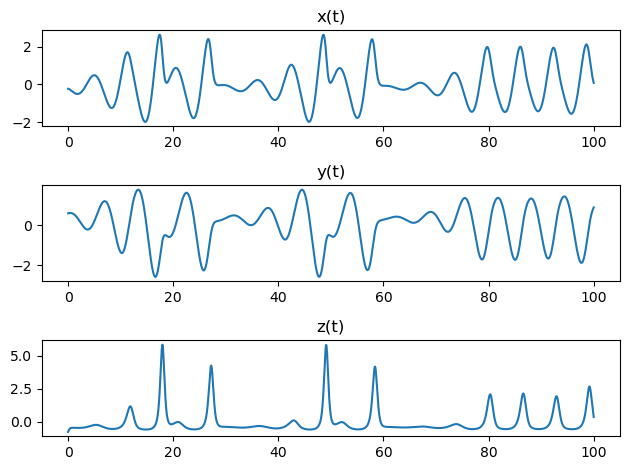

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Define the Rössler equations
def rossler(Y, a, b, c):
    x, y, z = Y
    dxdt = -y - z
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return np.array([dxdt, dydt, dzdt])

# Parameters
a = 0.5
b = 2.0
c = 4.0

# Initial conditions
Y = np.array([0.1, 0, 0])

# Time step and total time
dt = 0.001
T = 100
n_steps = int(T/dt)

# Create an array to store the solution
solution = np.zeros((n_steps, 3))
solution[0] = Y

# Time grid for integration
t = np.linspace(0, T, n_steps)

# Euler's method
for i in range(1, n_steps):
    Y = Y + rossler(Y, a, b, c) * dt
    solution[i] = Y
solution = zscore(solution, axis=0)  # Normalize the solution

# Define function to create training data for reservoir computing
def create_rc_training_data_multi(solution, N):
    data = {}
    for i in range(3):  # For each coordinate (x, y, z)
        X, Y = [], []
        for j in range(len(solution) - N):
            X.append(solution[j:j+N, i])
            Y.append(np.delete(solution[j:j+N, :], i, axis=1))
        data[f"X_train_{i}"] = np.array(X)
        data[f"Y_train_{i}"] = np.array(Y)
    return data

# Create training data with sequence length N
N = 10
training_data = create_rc_training_data_multi(solution, N)

# Print shape of training data
for k, v in training_data.items():
    print(f"Shape of {k}:", v.shape)


# Plot the solution
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(t, solution[:, 0])
plt.title('x(t)')
plt.subplot(3, 1, 2)
plt.plot(t, solution[:, 1])
plt.title('y(t)')
plt.subplot(3, 1, 3)
plt.plot(t, solution[:, 2])
plt.title('z(t)')
plt.tight_layout()
plt.show()


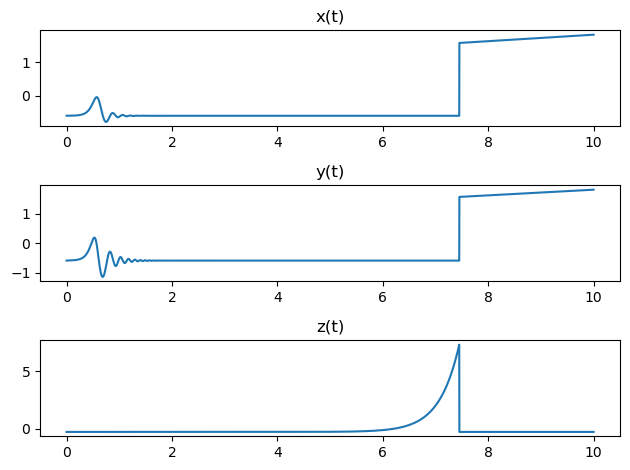

Shape of X_train_0: (9990, 10)
Shape of Y_train_0: (9990, 10, 2)
Shape of X_train_1: (9990, 10)
Shape of Y_train_1: (9990, 10, 2)
Shape of X_train_2: (9990, 10)
Shape of Y_train_2: (9990, 10, 2)


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the Lorenz equations
def lorenz(Y, t, a, b, c):
    x, y, z = Y
    dxdt = (-a*x) + (a*y)
    dydt = (b*x) - y - (x*z)
    dzdt = c*z + x*y
    return [dxdt, dydt, dzdt]

# Parameters
a = 10
b = 28
c = 8/3

# Initial conditions
Y = np.array([0.1, 0.0, 0.0])

# Time step and total time
dt = 0.001
T = 10
n_steps = int(T/dt)

# Time grid for integration
t = np.linspace(0, T, n_steps)

# Solve the differential equations using odeint
solution_lorenz = odeint(lorenz, Y, t, args=(a, b, c))
solution_lorenz = zscore(solution_lorenz, axis=0)  # Normalize the solution

# Plot the solution
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(t, solution_lorenz[:, 0])
plt.title('x(t)')
plt.subplot(3, 1, 2)
plt.plot(t, solution_lorenz[:, 1])
plt.title('y(t)')
plt.subplot(3, 1, 3)
plt.plot(t, solution_lorenz[:, 2])
plt.title('z(t)')
plt.tight_layout()
plt.show()

# Define function to create training data for reservoir computing
def create_rc_training_data_multi_lorenz(solution, N):
    data = {}
    for i in range(3):  # For each coordinate (x, y, z)
        X, Y = [], []
        for j in range(len(solution) - N):
            X.append(solution[j:j+N, i])
            Y.append(np.delete(solution[j:j+N, :], i, axis=1))
        data[f"X_train_{i}"] = np.array(X)
        data[f"Y_train_{i}"] = np.array(Y)
    return data

# Create training data with sequence length N
N = 10
training_data_lorenz = create_rc_training_data_multi_lorenz(solution_lorenz, N)

# Print shape of training data
for k, v in training_data_lorenz.items():
    print(f"Shape of {k}:", v.shape)

